In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'


In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import numpy as np
import pandas as pd
import h5py
import scipy.stats
from ostrich import emulate
import profile_emulator as profile_emu
   
from functools import partial
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
mp = 1.67e-24
Mpc = 3.0856e24
kpc = Mpc/1000.0
erg_to_keV = 6.242e+8
Zsun = 0.0127
Msun = 1.989e33 #g cm^-3
kb = 1.38e-16 # erg/K
erg_to_keV = 6.242e+8
K_to_keV = kb * erg_to_keV
XH = 0.76 #primordial hydrogen fraction
mu = 0.58824; # X=0.76 assumed 
mu_e = mue = 2.0/(1.0+XH); # X=0.76 assumed

In [4]:
from colossus.cosmology import cosmology

OmegaM = 0.3089
sigma8 = 0.8102
cosmo = cosmology.setCosmology('myCosmo', params = cosmology.cosmologies['planck18'], Om0 = OmegaM, sigma8=sigma8)
fb = cosmo.Ob0 / cosmo.Om0 


In [5]:
suite_list = ['IllustrisTNG'] #SIMBA or IllustrisTNG

In [6]:
def plot_Mgas_M200c(z, suite='IllustrisTNG') :

    M200c = np.logspace(12, 13.5, 10)

    fig, axes = plt.subplots(2, 2, figsize=[7, 6],facecolor='white', sharex=True, sharey=True, layout='compressed')
    axes[0,0].set_xscale('log')
    axes[0,0].set_yscale('log')

    asn1_list = np.logspace(np.log10(0.25), np.log10(4.0), 11)
    aagn1_list = np.logspace(np.log10(0.25), np.log10(4.0), 11)
    asn2_list = np.logspace(np.log10(0.5), np.log10(2.0), 11)
    if suite == 'Astrid':
        aagn2_list = np.logspace(np.log10(0.25), np.log10(4.0), 11)
    else :
        aagn2_list = np.logspace(np.log10(0.5), np.log10(2.0), 11)

    color_list=cm.coolwarm(np.linspace(0,1,len(asn1_list))) 
    
    pfunc = partial(profile_emu.Mgas_M200c_scaling, suite, z, (M200c))
    
    label_loc = (0.15, 0.85)

    for i, param in enumerate(asn1_list) :
        popt = param, 1,1,1
        model_pro = pfunc(*popt)
        im00 = axes[0,0].loglog(M200c, model_pro, color=color_list[i])
    axes[0,0].annotate(r'$A_{\rm SN1}$', xy=label_loc, xycoords='axes fraction', fontsize=20)

    for i, param in enumerate(aagn1_list) :
        popt = 1, param, 1,1
        model_pro = pfunc(*popt)
        im01 = axes[0,1].loglog(M200c, model_pro, color=color_list[i])
    axes[0,1].annotate(r'$A_{\rm AGN1}$', xy=label_loc, xycoords='axes fraction', fontsize=20)

    for i, param in enumerate(asn2_list) :
        popt = [1,1,param,1]
        model_pro = pfunc(*popt)
        im10 = axes[1,0].loglog(M200c, model_pro, color=color_list[i])
    axes[1,0].annotate(r'$A_{\rm SN2}$', xy=label_loc, xycoords='axes fraction', fontsize=20)

    for i, param in enumerate(aagn2_list) :
        popt = [1,1,1,param]
        model_pro = pfunc(*popt)
        im11 = axes[1,1].loglog(M200c, model_pro, color=color_list[i])
    axes[1,1].annotate(r'$A_{\rm AGN2}$', xy=label_loc, xycoords='axes fraction', fontsize=20)


    ticks0 = [0.25, 0.5, 1.0, 2.0, 4.0]
    ticks1 = [0.5, 0.75, 1.0, 1.5, 2.0]
    
    sm0 = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=colors.LogNorm(vmin=0.25, vmax=4.0))
    cbar00 = plt.colorbar(sm0, ax=axes[0,0], ticks=ticks0)
    cbar01 = plt.colorbar(sm0, ax=axes[0,1], ticks=ticks0)
    sm1 = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=colors.LogNorm(vmin=0.5, vmax=2.0))
    cbar10 = plt.colorbar(sm1, ax=axes[1,0], ticks=ticks1)
    if suite == 'Astrid':
        cbar11 = plt.colorbar(sm0, ax=axes[1,1], ticks=ticks0)
    else :
        cbar11 = plt.colorbar(sm1, ax=axes[1,1], ticks=ticks1)

    cbar00.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks0])
    cbar01.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks0])
    cbar10.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks1])
    
    if suite=='Astrid':
        cbar11.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks0])
    else :
        cbar11.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks1])

    cbar00.ax.minorticks_off()
    cbar01.ax.minorticks_off()
    cbar10.ax.minorticks_off()
    cbar11.ax.minorticks_off()
    
    #axes[0,0].set_xlim(10,1000)
    axes[0,0].set_ylabel(r'$M_{\rm gas}\,[M_\odot]$')
    axes[1,0].set_ylabel(r'$M_{\rm gas}\,[M_\odot]$')
    axes[1,1].set_xlabel(r'$M_{200c}\,[M_\odot]$')
    axes[1,0].set_xlabel(r'$M_{200c}\,[M_\odot]$')

    #title_str = (r''+suite+r': $\log_{10}(M_{200c}/M_\odot)='+'{0:.2f}'.format(M200c)+'$'+ 
    #             r', $z ='+str(z)+'$')
    
    
    #fig.suptitle(title_str,fontsize=16)
    plt.show()


In [7]:
def plot_fgas_M200c(z, suite='IllustrisTNG') :

    
    M200c = np.logspace(12, 13.5, 10)

    fig, axes = plt.subplots(2, 2, figsize=[7, 6],facecolor='white', sharex=True, sharey=True, layout='compressed')
    axes[0,0].set_xscale('log')
    axes[0,0].set_yscale('log')

    asn1_list = np.logspace(np.log10(0.25), np.log10(4.0), 11)
    aagn1_list = np.logspace(np.log10(0.25), np.log10(4.0), 11)
    asn2_list = np.logspace(np.log10(0.5), np.log10(2.0), 11)
    if suite == 'Astrid':
        aagn2_list = np.logspace(np.log10(0.25), np.log10(4.0), 11)
    else :
        aagn2_list = np.logspace(np.log10(0.5), np.log10(2.0), 11)

    color_list=cm.coolwarm(np.linspace(0,1,len(asn1_list))) 
    
    pfunc = partial(profile_emu.Mgas_M200c_scaling, suite, z, (M200c))
    
    label_loc = (0.15, 0.85)

    for i, param in enumerate(asn1_list) :
        popt = param, 1,1,1
        model_pro = pfunc(*popt)
        im00 = axes[0,0].loglog(M200c, model_pro/M200c/fb, color=color_list[i])
    axes[0,0].annotate(r'$A_{\rm SN1}$', xy=label_loc, xycoords='axes fraction', fontsize=20)

    for i, param in enumerate(aagn1_list) :
        popt = 1, param, 1,1
        model_pro = pfunc(*popt)
        im01 = axes[0,1].loglog(M200c, model_pro/M200c/fb, color=color_list[i])
    axes[0,1].annotate(r'$A_{\rm AGN1}$', xy=label_loc, xycoords='axes fraction', fontsize=20)

    for i, param in enumerate(asn2_list) :
        popt = [1,1,param,1]
        model_pro = pfunc(*popt)
        im10 = axes[1,0].loglog(M200c, model_pro/M200c/fb, color=color_list[i])
    axes[1,0].annotate(r'$A_{\rm SN2}$', xy=label_loc, xycoords='axes fraction', fontsize=20)

    for i, param in enumerate(aagn2_list) :
        popt = [1,1,1,param]
        model_pro = pfunc(*popt)
        im11 = axes[1,1].loglog(M200c, model_pro/M200c/fb, color=color_list[i])
    axes[1,1].annotate(r'$A_{\rm AGN2}$', xy=label_loc, xycoords='axes fraction', fontsize=20)


    ticks0 = [0.25, 0.5, 1.0, 2.0, 4.0]
    ticks1 = [0.5, 0.75, 1.0, 1.5, 2.0]
    
    sm0 = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=colors.LogNorm(vmin=0.25, vmax=4.0))
    cbar00 = plt.colorbar(sm0, ax=axes[0,0], ticks=ticks0)
    cbar01 = plt.colorbar(sm0, ax=axes[0,1], ticks=ticks0)
    sm1 = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=colors.LogNorm(vmin=0.5, vmax=2.0))
    cbar10 = plt.colorbar(sm1, ax=axes[1,0], ticks=ticks1)
    if suite == 'Astrid':
        cbar11 = plt.colorbar(sm0, ax=axes[1,1], ticks=ticks0)
    else :
        cbar11 = plt.colorbar(sm1, ax=axes[1,1], ticks=ticks1)

    cbar00.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks0])
    cbar01.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks0])
    cbar10.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks1])
    
    if suite=='Astrid':
        cbar11.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks0])
    else :
        cbar11.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks1])

    cbar00.ax.minorticks_off()
    cbar01.ax.minorticks_off()
    cbar10.ax.minorticks_off()
    cbar11.ax.minorticks_off()
    
    axes[0,0].set_ylim(0.03,1.0)
    axes[0,0].set_ylabel(r'$f_{\rm gas}\,[\Omega_b/\Omega_M]$')
    axes[1,0].set_ylabel(r'$f_{\rm gas}\,[\Omega_b/\Omega_M]$')
    axes[1,1].set_xlabel(r'$M_{200c}\,[M_\odot]$')
    axes[1,0].set_xlabel(r'$M_{200c}\,[M_\odot]$')

    #title_str = (r''+suite+r': $\log_{10}(M_{200c}/M_\odot)='+'{0:.2f}'.format(M200c)+'$'+ 
    #             r', $z ='+str(z)+'$')
    
    
    #fig.suptitle(title_str,fontsize=16)
    plt.show()


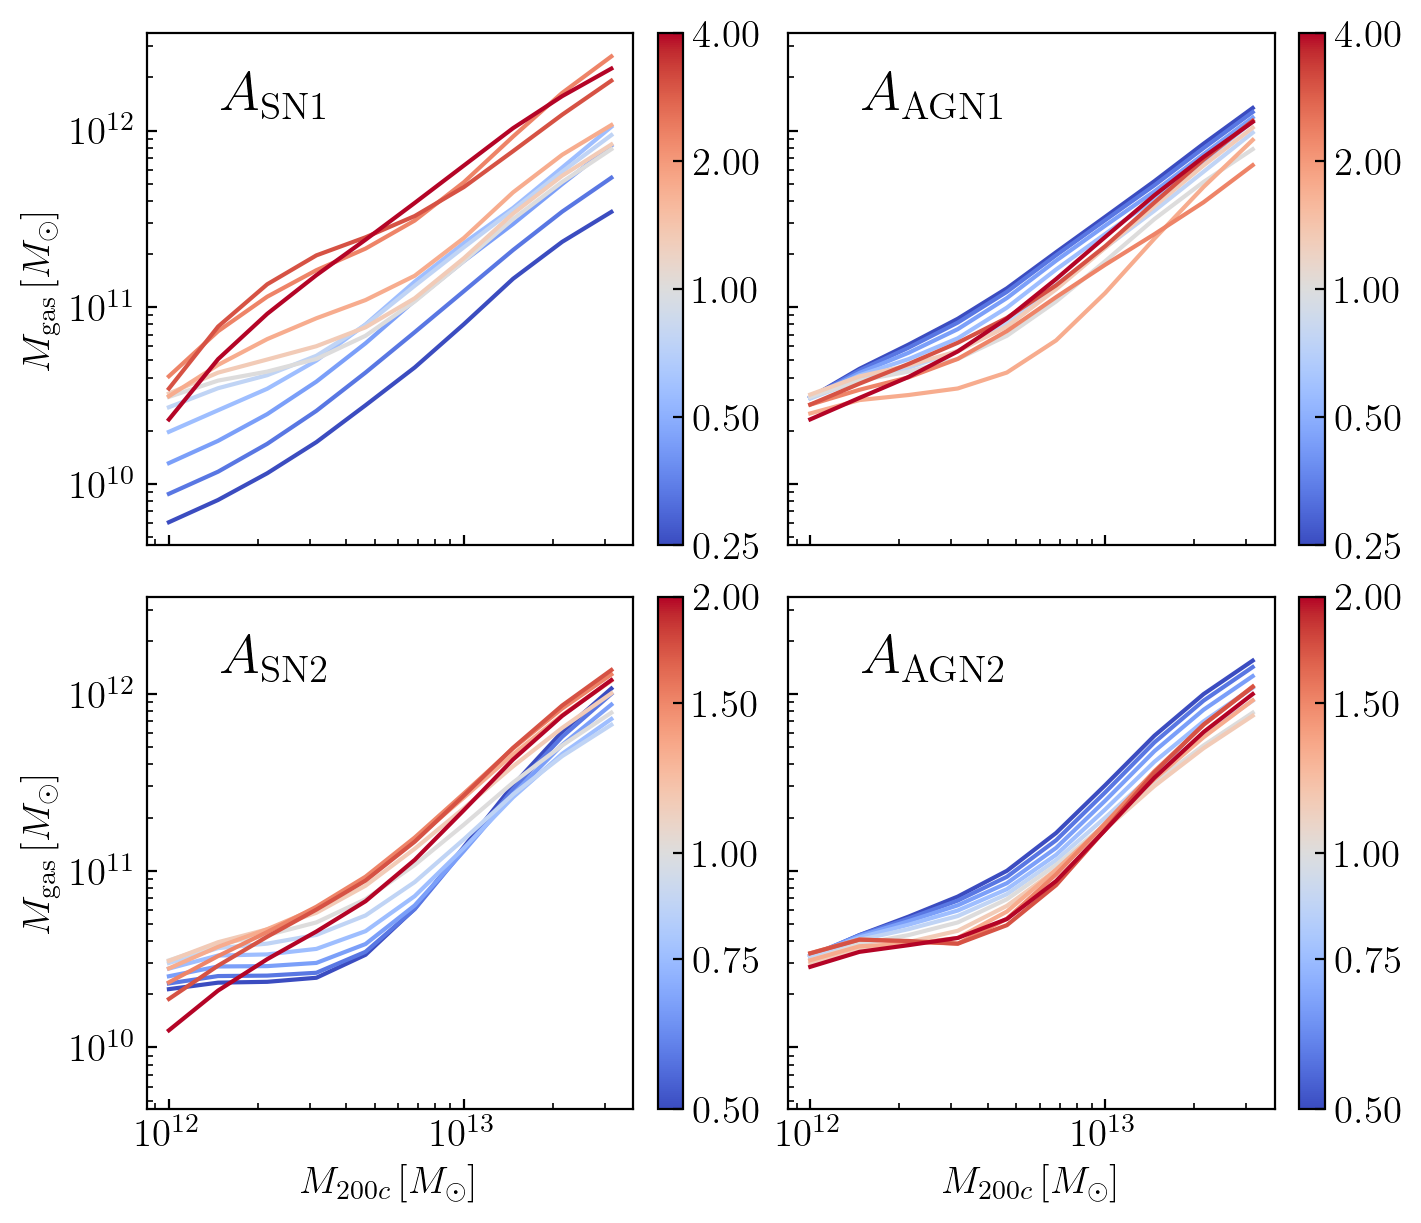

In [8]:
z = 0.1
plot_Mgas_M200c(z)

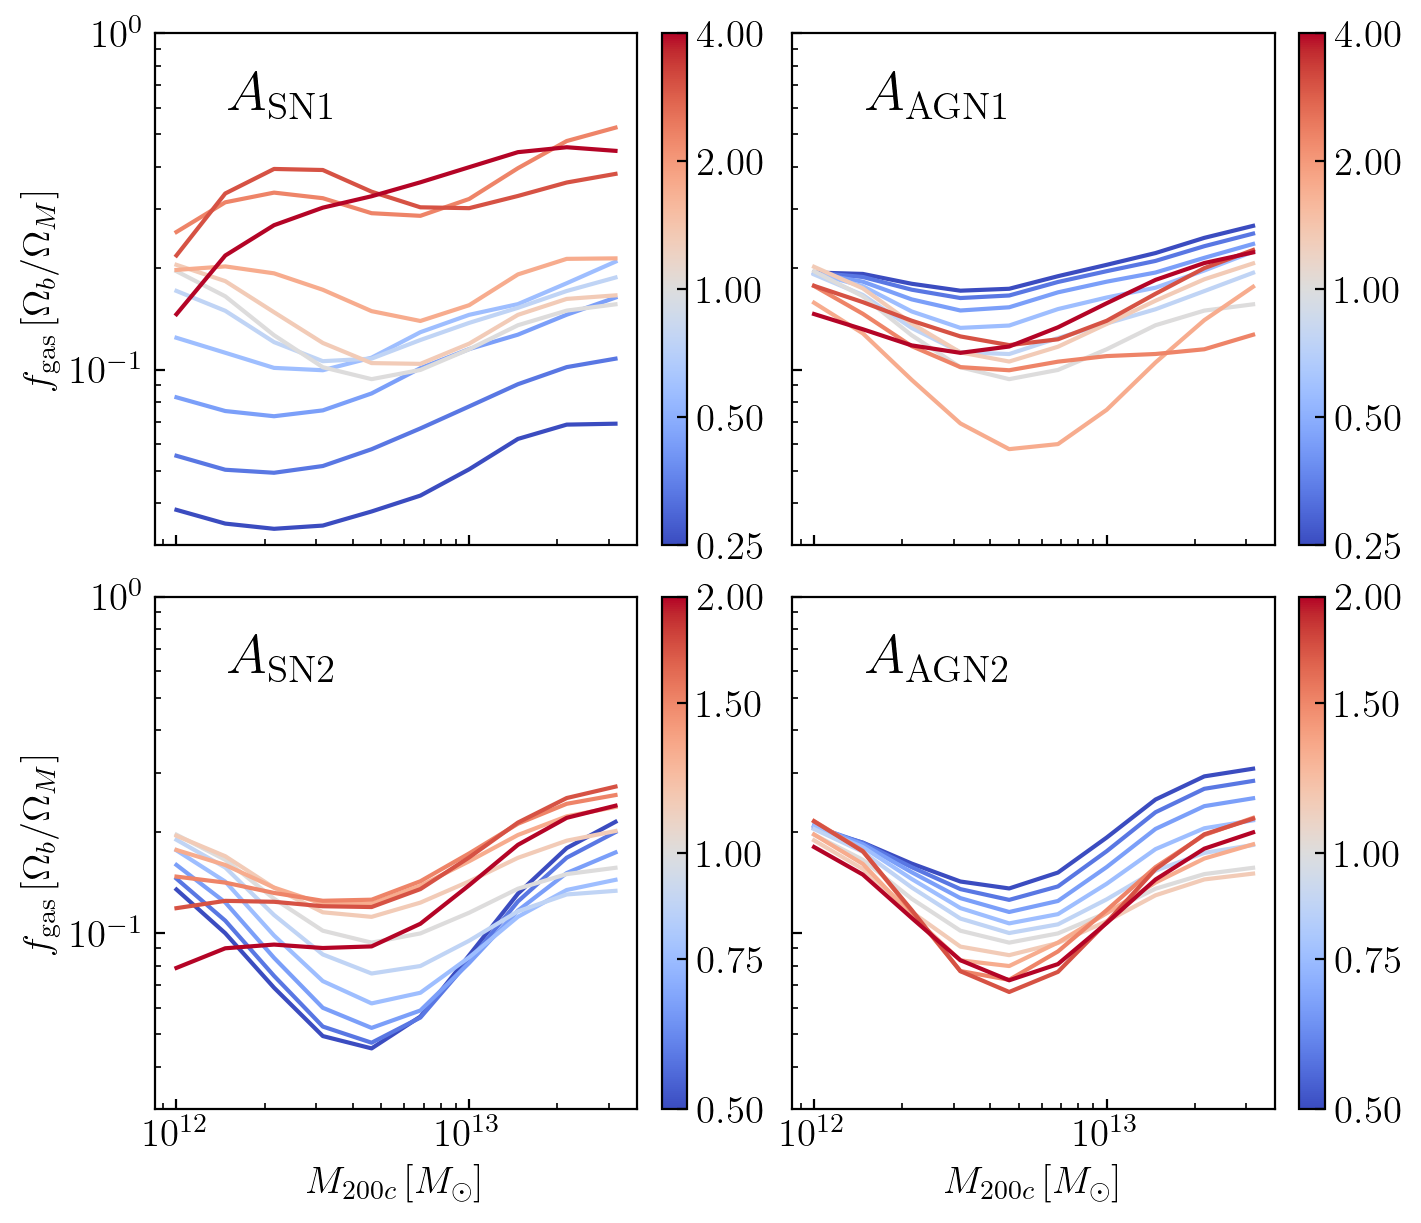

In [9]:
plot_fgas_M200c(z)

In [10]:
def plot_density_profile(z, logM200c, suite='IllustrisTNG') :

    fig, axes = plt.subplots(2, 2, figsize=[7, 6],facecolor='white', sharex=True, sharey=True, layout='compressed')
    axes[0,0].set_xscale('log')
    axes[0,0].set_yscale('log')

    asn1_list = np.logspace(np.log10(0.25), np.log10(4.0), 11)
    aagn1_list = np.logspace(np.log10(0.25), np.log10(4.0), 11)
    asn2_list = np.logspace(np.log10(0.5), np.log10(2.0), 11)
    if suite == 'Astrid':
        aagn2_list = np.logspace(np.log10(0.25), np.log10(4.0), 11)
    else :
        aagn2_list = np.logspace(np.log10(0.5), np.log10(2.0), 11)

    color_list=cm.coolwarm(np.linspace(0,1,len(asn1_list))) 

    pfunc = partial(profile_emu.density_profile, suite, z, logM200c)

    rbins = np.logspace(1, 3, 100)
    
    label_loc = (0.65, 0.85)

    for i, param in enumerate(asn1_list) :
        popt = param, 1,1,1
        model_pro = pfunc(rbins, *popt)
        im00 = axes[0,0].plot(rbins, model_pro, color=color_list[i])
    axes[0,0].annotate(r'$A_{\rm SN1}$', xy=label_loc, xycoords='axes fraction', fontsize=20)

    for i, param in enumerate(aagn1_list) :
        popt = 1, param, 1,1
        model_pro = pfunc(rbins, *popt)
        im01 = axes[0,1].plot(rbins, model_pro, color=color_list[i])
    axes[0,1].annotate(r'$A_{\rm AGN1}$', xy=label_loc, xycoords='axes fraction', fontsize=20)

    for i, param in enumerate(asn2_list) :
        popt = [1,1,param,1]
        model_pro = pfunc(rbins, *popt)
        im10 = axes[1,0].plot(rbins, model_pro, color=color_list[i])
    axes[1,0].annotate(r'$A_{\rm SN2}$', xy=label_loc, xycoords='axes fraction', fontsize=20)

    for i, param in enumerate(aagn2_list) :
        popt = [1,1,1,param]
        model_pro = pfunc(rbins, *popt)
        im11 = axes[1,1].plot(rbins, model_pro, color=color_list[i])
    axes[1,1].annotate(r'$A_{\rm AGN2}$', xy=label_loc, xycoords='axes fraction', fontsize=20)


    ticks0 = [0.25, 0.5, 1.0, 2.0, 4.0]
    ticks1 = [0.5, 0.75, 1.0, 1.5, 2.0]
    
    sm0 = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=colors.LogNorm(vmin=0.25, vmax=4.0))
    cbar00 = plt.colorbar(sm0, ax=axes[0,0], ticks=ticks0)
    cbar01 = plt.colorbar(sm0, ax=axes[0,1], ticks=ticks0)
    sm1 = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=colors.LogNorm(vmin=0.5, vmax=2.0))
    cbar10 = plt.colorbar(sm1, ax=axes[1,0], ticks=ticks1)
    if suite == 'Astrid':
        cbar11 = plt.colorbar(sm0, ax=axes[1,1], ticks=ticks0)
    else :
        cbar11 = plt.colorbar(sm1, ax=axes[1,1], ticks=ticks1)

    cbar00.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks0])
    cbar01.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks0])
    cbar10.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks1])
    
    if suite=='Astrid':
        cbar11.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks0])
    else :
        cbar11.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks1])

    cbar00.ax.minorticks_off()
    cbar01.ax.minorticks_off()
    cbar10.ax.minorticks_off()
    cbar11.ax.minorticks_off()
    
    #axes[0,0].set_xlim(10,1000)
    axes[0,0].set_ylabel(r'$n_{\rm gas}\,[\mathrm{cm^{-3}}]$')
    axes[1,0].set_ylabel(r'$n_{\rm gas}\,[\mathrm{cm^{-3}}]$')
    axes[1,1].set_xlabel(r'$R_p\,[\mathrm{kpc}]$')
    axes[1,0].set_xlabel(r'$R_p\,[\mathrm{kpc}]$')

    title_str = (r''+suite+r': $\log_{10}(M_{200c}/M_\odot)='+'{0:.2f}'.format(logM200c)+'$'+ 
                 r', $z ='+str(z)+'$')
    
    fig.suptitle(title_str,fontsize=16)
    plt.show()


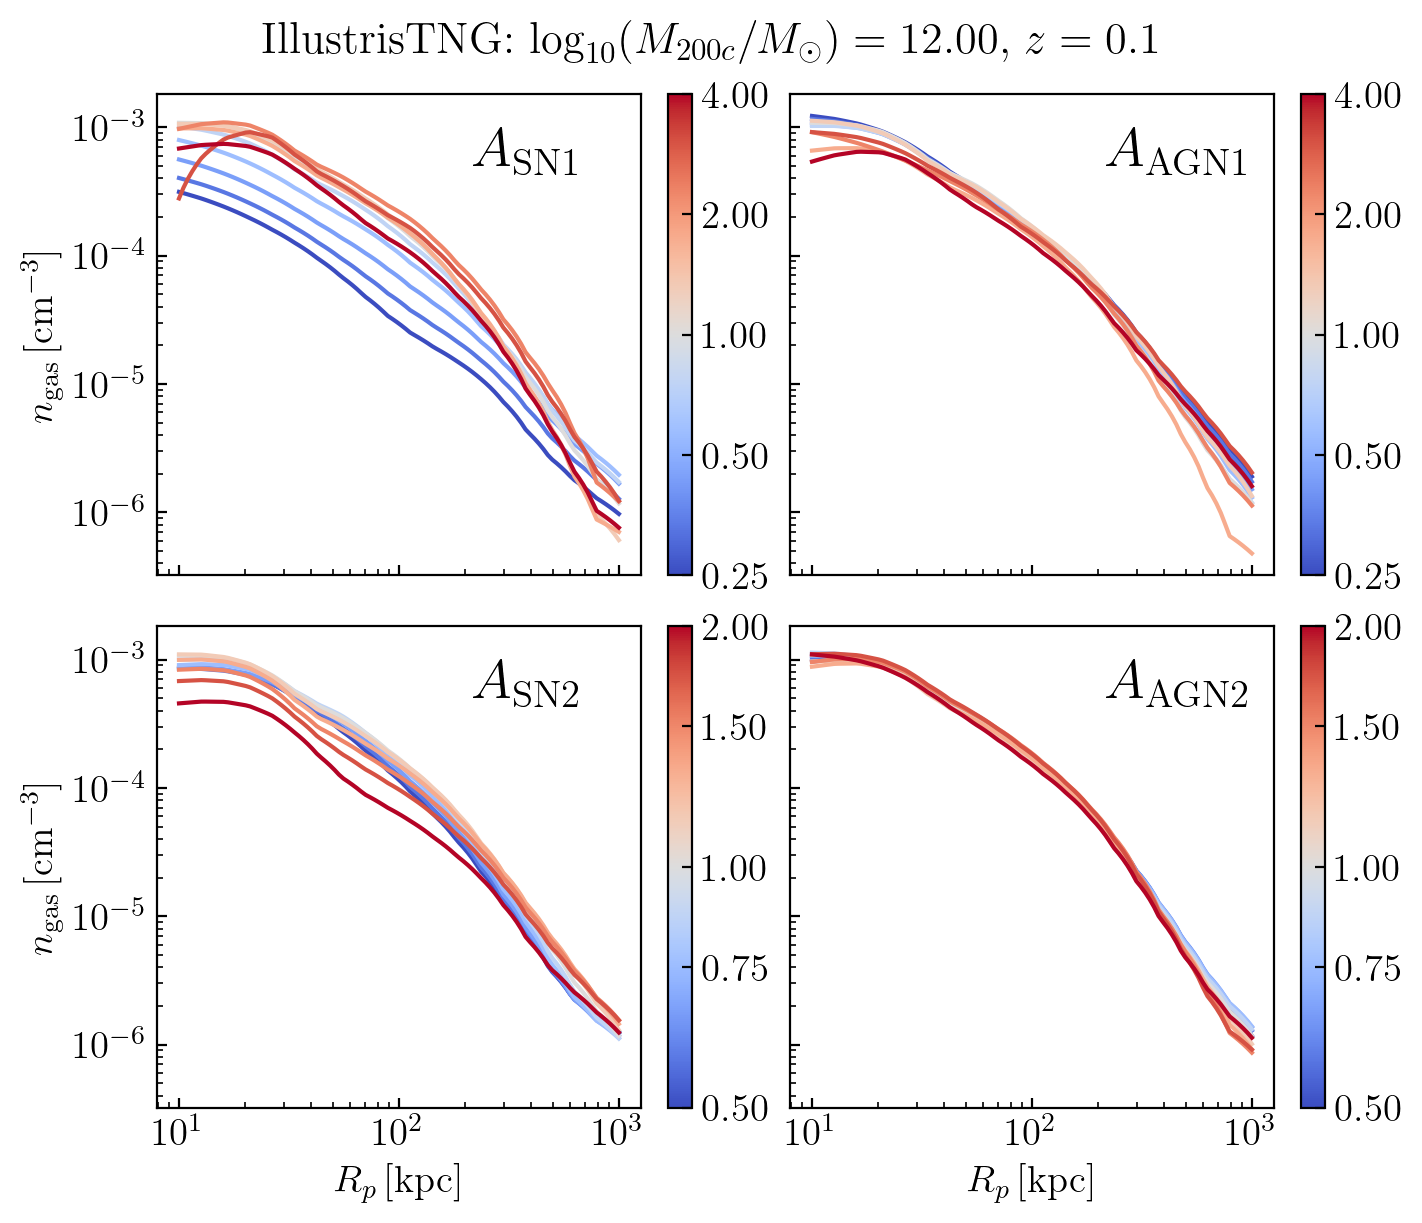

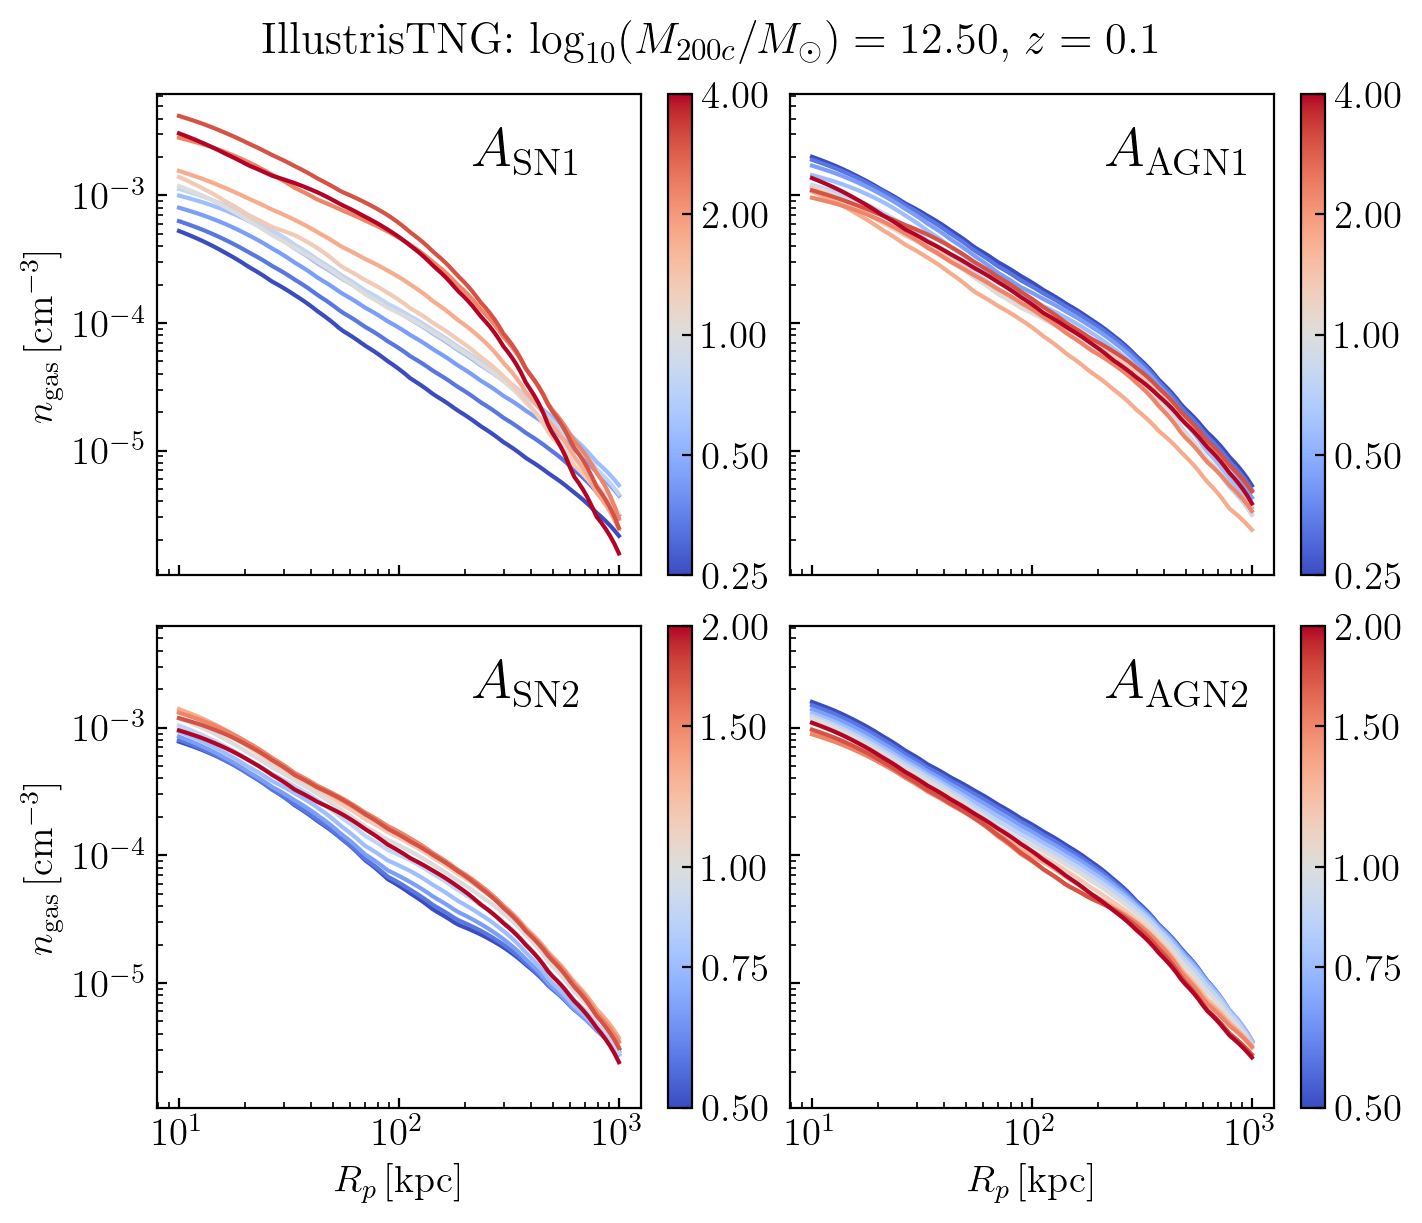

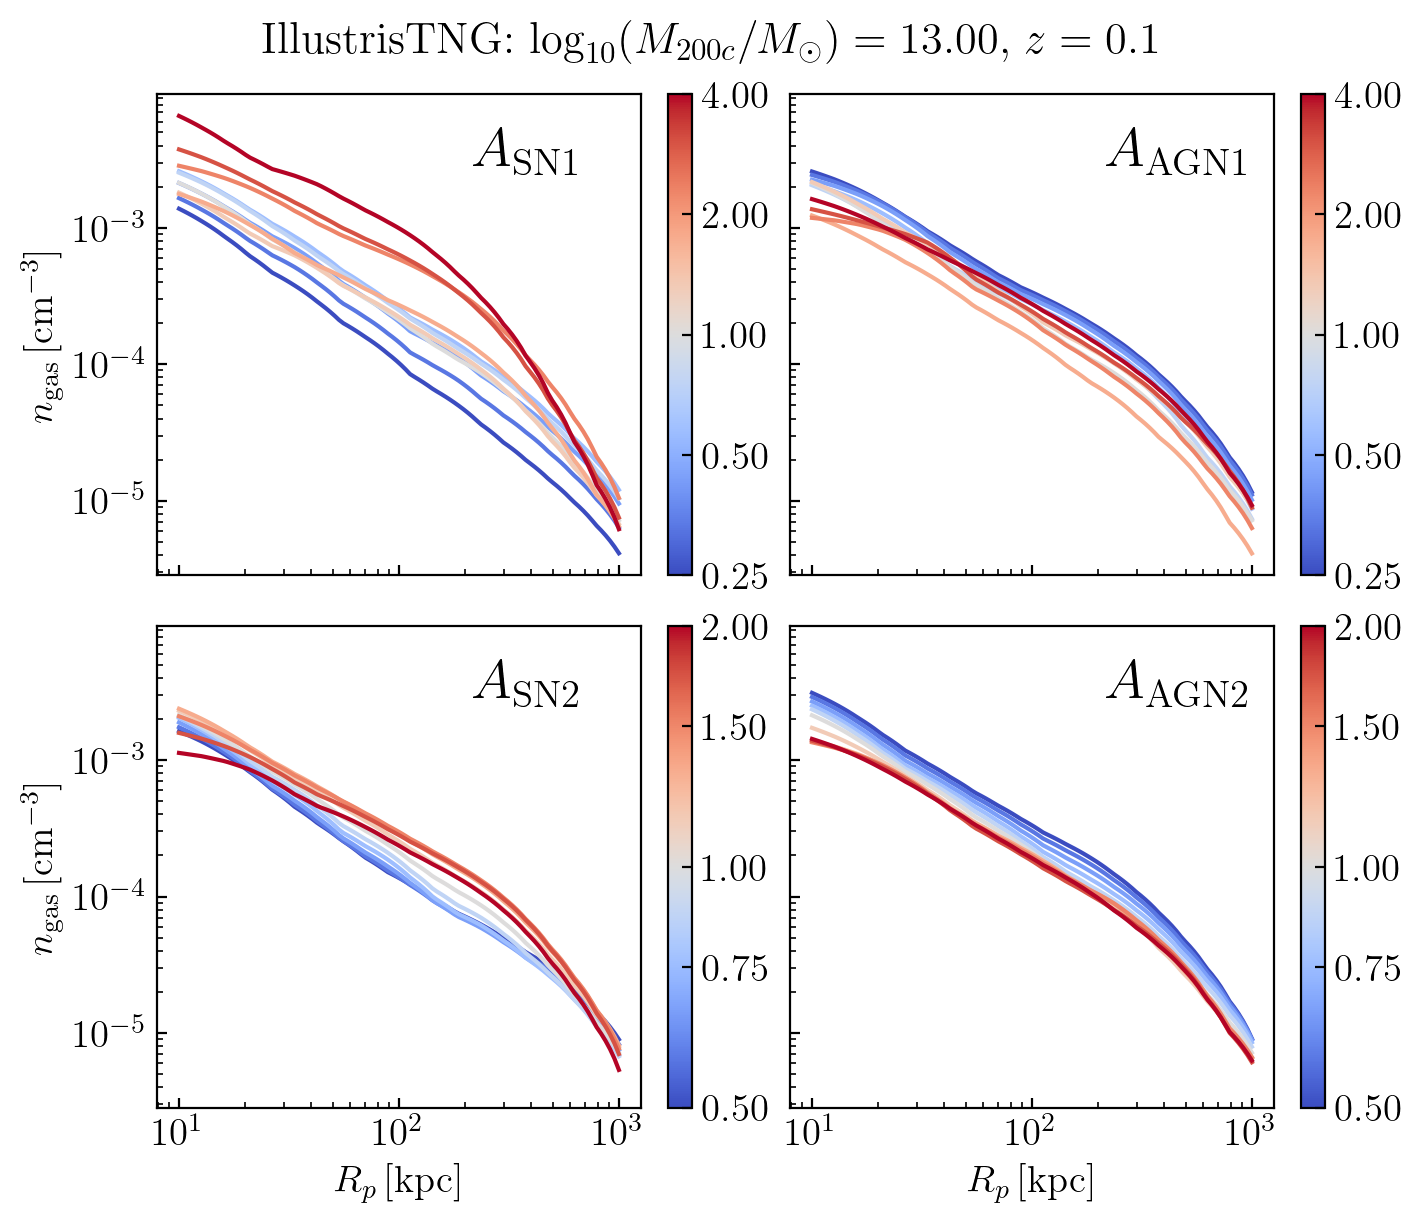

In [11]:
z = 0.1
for logM200c in [12, 12.5, 13.0]:
    plot_density_profile(z, logM200c)


In [12]:
def plot_temperature_profile(z, logM200c, suite='IllustrisTNG') :

    fig, axes = plt.subplots(2, 2, figsize=[7, 6],facecolor='white', sharex=True, sharey=True, layout='compressed')
    axes[0,0].set_xscale('log')
    axes[0,0].set_yscale('log')

    asn1_list = np.logspace(np.log10(0.25), np.log10(4.0), 11)
    aagn1_list = np.logspace(np.log10(0.25), np.log10(4.0), 11)
    asn2_list = np.logspace(np.log10(0.5), np.log10(2.0), 11)
    if suite == 'Astrid':
        aagn2_list = np.logspace(np.log10(0.25), np.log10(4.0), 11)
    else :
        aagn2_list = np.logspace(np.log10(0.5), np.log10(2.0), 11)
    color_list=cm.coolwarm(np.linspace(0,1,len(asn1_list))) 

    pfunc = partial(profile_emu.temperature_profile, suite, z, logM200c)

    rbins = np.logspace(1, 3, 100)
    label_loc = (0.65, 0.85)

    for i, param in enumerate(asn1_list) :
        popt = param, 1,1,1
        model_pro = pfunc(rbins, *popt)
        im00 = axes[0,0].plot(rbins, model_pro, color=color_list[i])
    axes[0,0].annotate(r'$A_{\rm SN1}$', xy=label_loc, xycoords='axes fraction', fontsize=20)

    for i, param in enumerate(aagn1_list) :
        popt = 1, param, 1,1
        model_pro = pfunc(rbins, *popt)
        im01 = axes[0,1].plot(rbins, model_pro, color=color_list[i])
    axes[0,1].annotate(r'$A_{\rm AGN1}$', xy=label_loc, xycoords='axes fraction', fontsize=20)

    for i, param in enumerate(asn2_list) :
        popt = [1,1,param,1]
        model_pro = pfunc(rbins, *popt)
        im10 = axes[1,0].plot(rbins, model_pro, color=color_list[i])
    axes[1,0].annotate(r'$A_{\rm SN2}$', xy=label_loc, xycoords='axes fraction', fontsize=20)

    for i, param in enumerate(aagn2_list) :
        popt = [1,1,1,param]
        model_pro = pfunc(rbins, *popt)
        im11 = axes[1,1].plot(rbins, model_pro, color=color_list[i])
    axes[1,1].annotate(r'$A_{\rm AGN2}$', xy=label_loc, xycoords='axes fraction', fontsize=20)


    ticks0 = [0.25, 0.5, 1.0, 2.0, 4.0]
    ticks1 = [0.5, 0.75, 1.0, 1.5, 2.0]
    
    sm0 = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=colors.LogNorm(vmin=0.25, vmax=4.0))
    cbar00 = plt.colorbar(sm0, ax=axes[0,0], ticks=ticks0)
    cbar01 = plt.colorbar(sm0, ax=axes[0,1], ticks=ticks0)
    sm1 = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=colors.LogNorm(vmin=0.5, vmax=2.0))
    cbar10 = plt.colorbar(sm1, ax=axes[1,0], ticks=ticks1)
    if suite == 'Astrid':
        cbar11 = plt.colorbar(sm0, ax=axes[1,1], ticks=ticks0)
    else :
        cbar11 = plt.colorbar(sm1, ax=axes[1,1], ticks=ticks1)

    cbar00.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks0])
    cbar01.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks0])
    cbar10.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks1])
    
    if suite=='Astrid':
        cbar11.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks0])
    else :
        cbar11.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks1])

    cbar00.ax.minorticks_off()
    cbar01.ax.minorticks_off()
    cbar10.ax.minorticks_off()
    cbar11.ax.minorticks_off()

    #axes[0,0].set_xlim(10,1000)
    axes[0,0].set_ylabel(r'$T\,[\mathrm{keV}]$')
    axes[1,0].set_ylabel(r'$T\,[\mathrm{keV}]$')
    axes[1,1].set_xlabel(r'$R_p\,[\mathrm{kpc}]$')
    axes[1,0].set_xlabel(r'$R_p\,[\mathrm{kpc}]$')

    title_str = (r''+suite+r': $\log_{10}(M_{200c}/M_\odot)='+'{0:.2f}'.format(logM200c)+'$'+ 
                 r', $z ='+str(z)+'$')
    
    fig.suptitle(title_str,fontsize=16)
    plt.show()


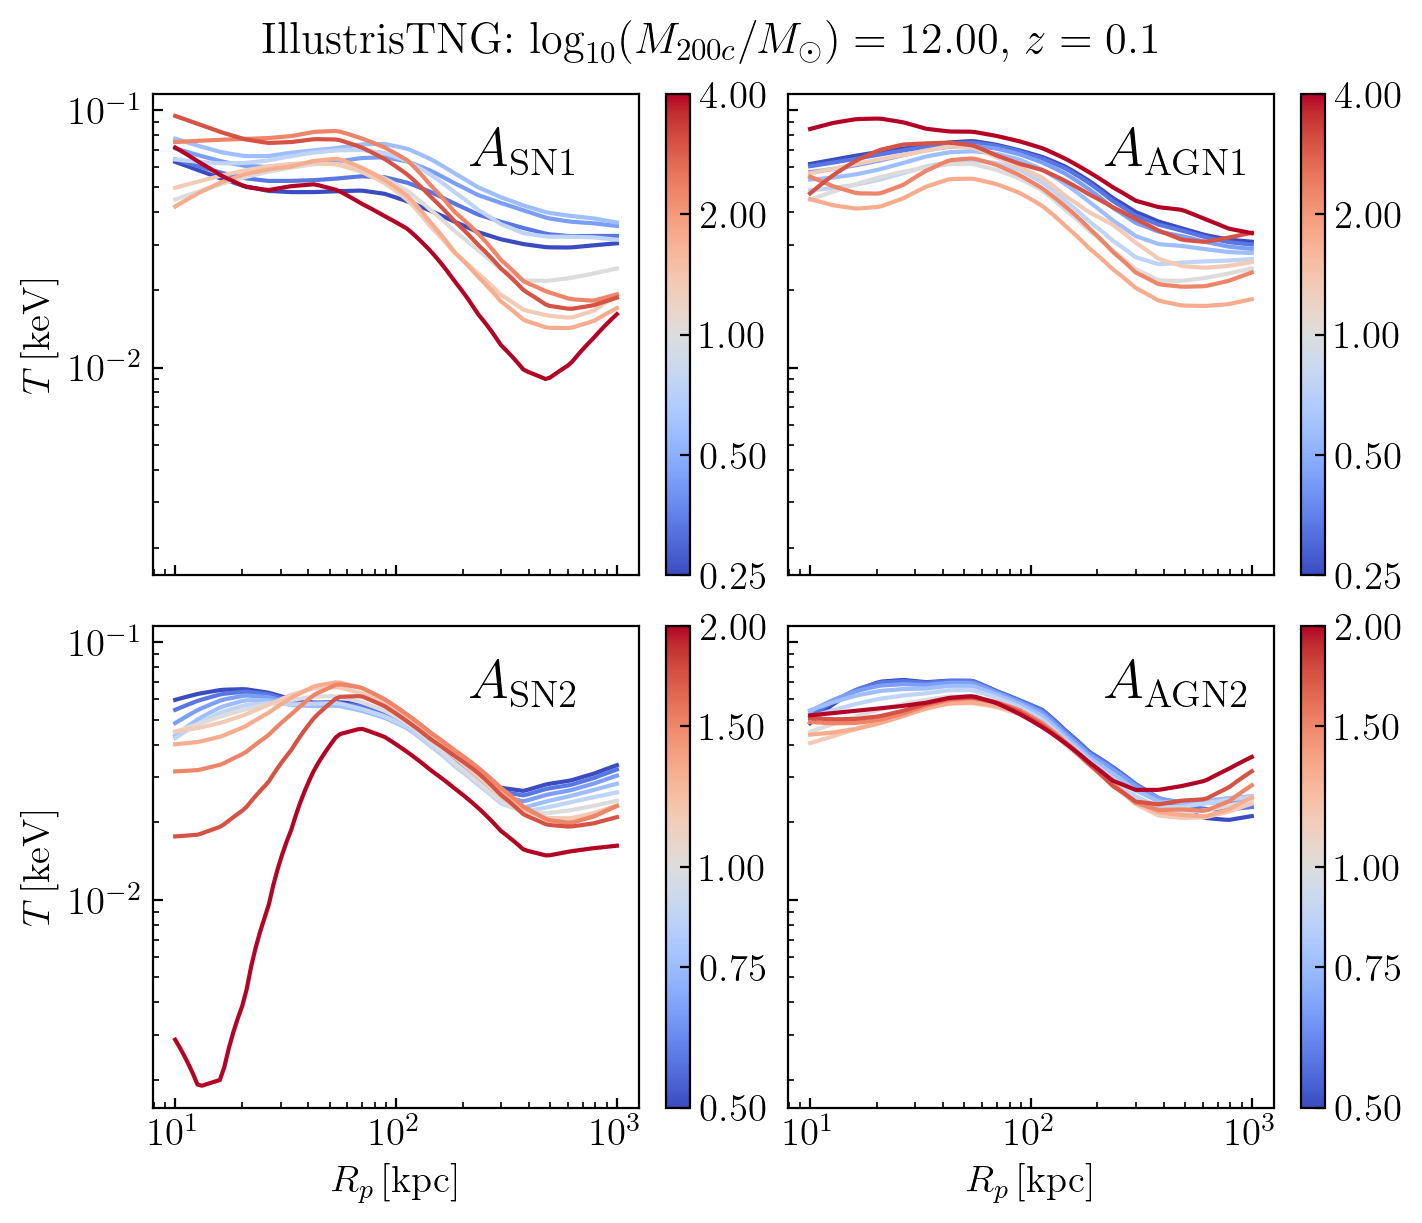

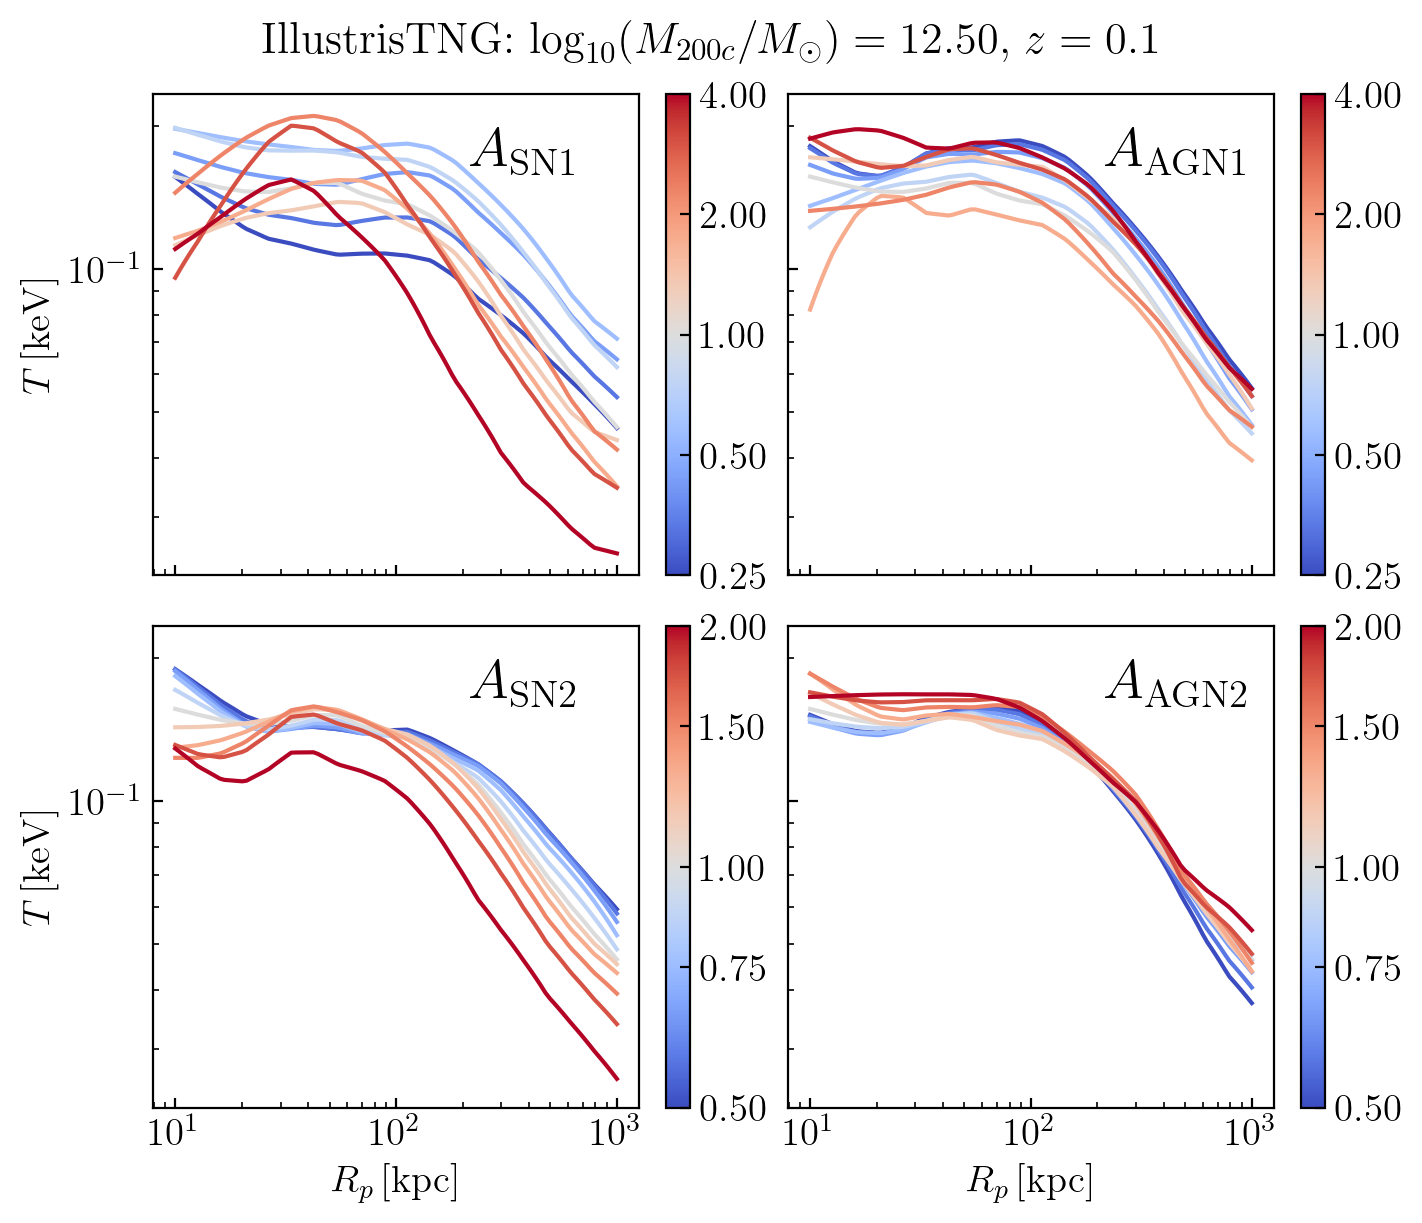

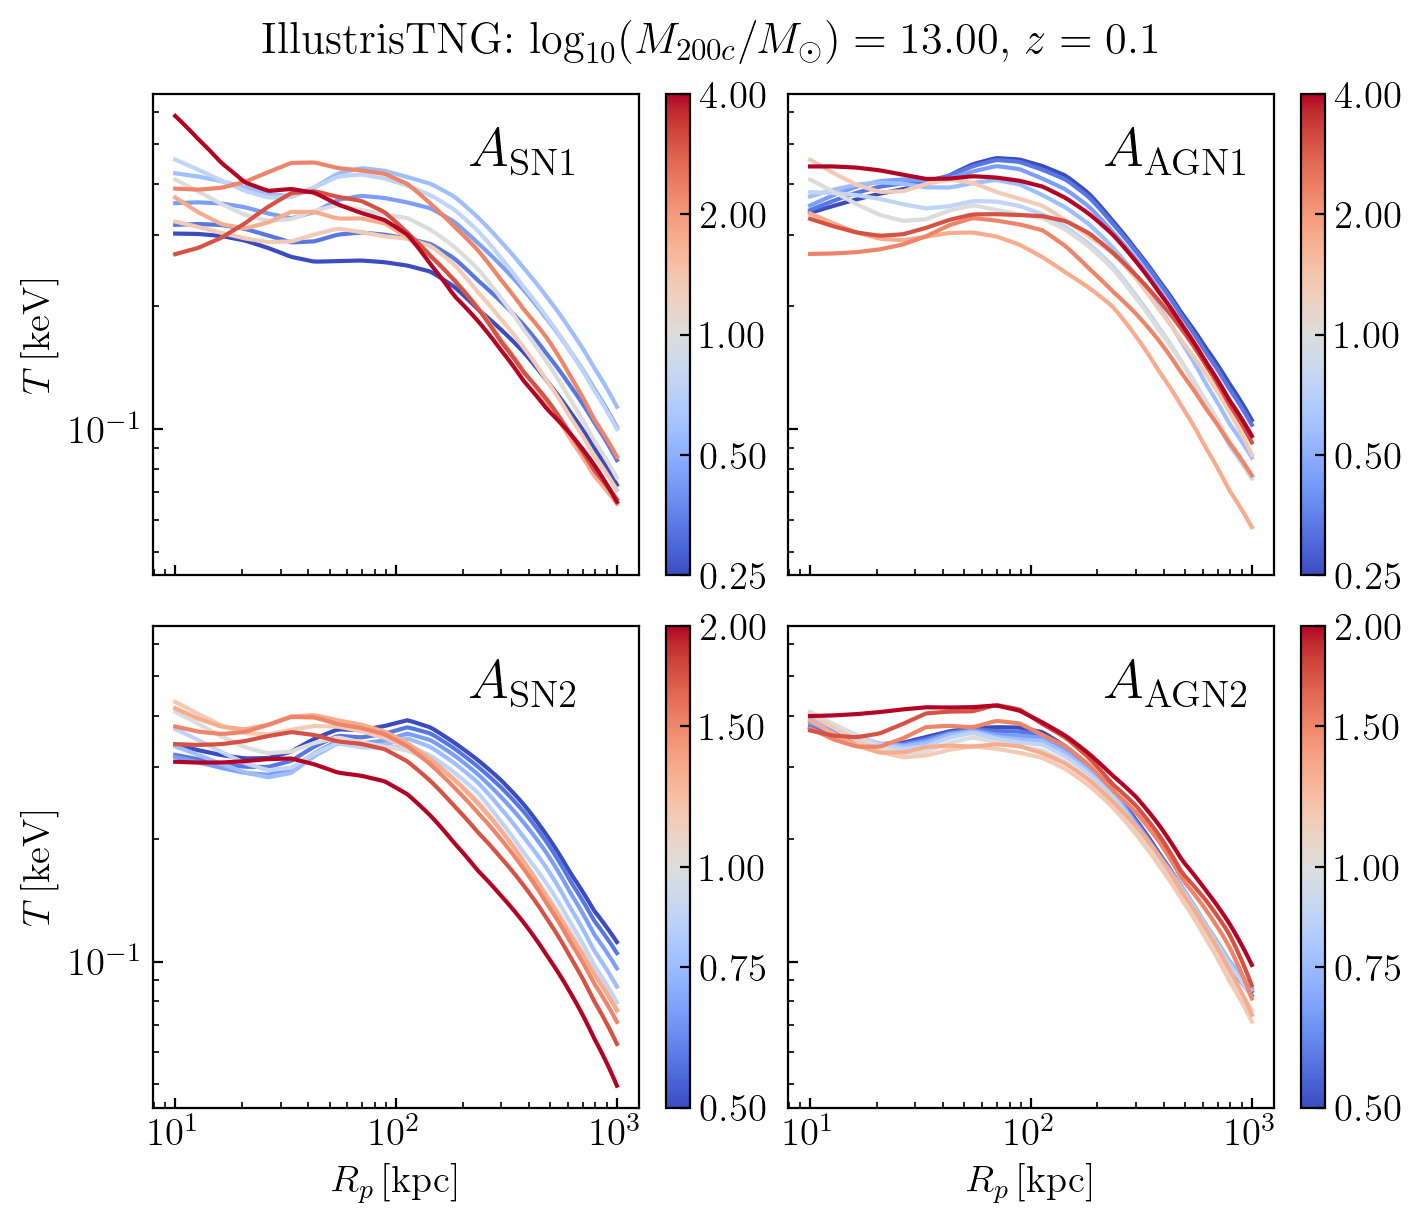

In [13]:
z = 0.1
for logM200c in [12, 12.5, 13.0]:
    plot_temperature_profile(z, logM200c)
